<a href="https://colab.research.google.com/github/TaarMaan/LrNK_Artamonov-Smirnov-/blob/main/LrNK_Artamono_Smirnov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

from matplotlib import pyplot as plt

from nltk.corpus import brown
from nltk.corpus import treebank
from nltk.corpus import conll2000

import seaborn as sns

from gensim.models import KeyedVectors

from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.models import Model
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
import nltk
nltk.download('brown')
nltk.download('treebank')
nltk.download('conll2000')
nltk.download('universal_tagset')
treebank_corpus = treebank.tagged_sents(tagset='universal')
brown_corpus = brown.tagged_sents(tagset='universal')
conll_corpus = conll2000.tagged_sents(tagset='universal')
tagged_sentences =  brown_corpus +conll_corpus+treebank_corpus

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


In [3]:
len(tagged_sentences)

72202

In [4]:
from yaml import tokens
from nltk.text import Text 
tb = Text(nltk.corpus.treebank.tagged_words(tagset='universal'))
tb[:10]

[('Pierre', 'NOUN'),
 ('Vinken', 'NOUN'),
 (',', '.'),
 ('61', 'NUM'),
 ('years', 'NOUN'),
 ('old', 'ADJ'),
 (',', '.'),
 ('will', 'VERB'),
 ('join', 'VERB'),
 ('the', 'DET')]

In [5]:
DataSet = open('/content/drive/MyDrive/LrNK/test_text.txt', "r", encoding="utf-8")
text = DataSet.read()
from nltk import word_tokenize
nltk.download('punkt')
text_tokens = word_tokenize(text)
tt = Text(text_tokens[:10])
print(type(text_tokens), len(text_tokens))
text_tokens[:10]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


<class 'list'> 1119


['At', 'the', 'beginning', 'of', 'July', ',', 'at', 'an', 'extremely', 'hot']

In [6]:
X = [] # store input sequence
Y = [] # store output sequence

for sentence in tagged_sentences:
    X_sentence = []
    Y_sentence = []
    for entity in sentence:         
        X_sentence.append(entity[0])  # entity[0] contains the word
        Y_sentence.append(entity[1])  # entity[1] contains corresponding tag
        
    X.append(X_sentence)
    Y.append(Y_sentence)

In [7]:
num_words = len(set([word.lower() for sentence in X for word in sentence]))
num_tags   = len(set([word.lower() for sentence in Y for word in sentence]))

In [8]:
print("Total number of tagged sentences: {}".format(len(X)))
print("Vocabulary size: {}".format(num_words))
print("Total number of tags: {}".format(num_tags))

Total number of tagged sentences: 72202
Vocabulary size: 59448
Total number of tags: 12


In [9]:
print('sample X: ', X[0], '\n')
print('sample Y: ', Y[0], '\n')

sample X:  ['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'] 

sample Y:  ['DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.'] 



In [10]:
print("Length of first input sequence  : {}".format(len(X[0])))
print("Length of first output sequence : {}".format(len(Y[0])))

Length of first input sequence  : 25
Length of first output sequence : 25


In [11]:
word_tokenizer = Tokenizer()                      
word_tokenizer.fit_on_texts(X)                  
X_encoded = word_tokenizer.texts_to_sequences(X)

In [12]:
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

In [13]:
print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', X[0], '\n')
print('Y: ', Y[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_encoded[0], '\n')
print('Y: ', Y_encoded[0], '\n')

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'] 

Y:  ['DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.'] 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [1, 5731, 778, 2326, 1842, 39, 853, 34, 1944, 4, 16831, 379, 1343, 1523, 1116, 12, 67, 569, 14, 9, 89, 10208, 252, 205, 3] 

Y:  [5, 1, 1, 6, 1, 2, 1, 5, 1, 4, 1, 6, 1, 1, 2, 3, 5, 1, 3, 4, 5, 1, 2, 1, 3] 



In [14]:
different_length = [1 if len(input) != len(output) else 0 for input, output in zip(X_encoded, Y_encoded)]
print("{} sentences have disparate input-output lengths.".format(sum(different_length)))

0 sentences have disparate input-output lengths.


In [15]:
lengths = [len(seq) for seq in X_encoded]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 271


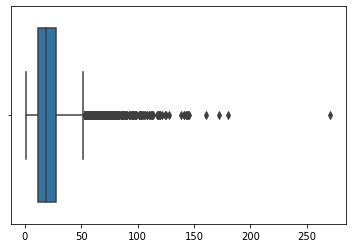

In [16]:
sns.boxplot(lengths)
plt.show()

In [17]:
MAX_SEQ_LENGTH = 100  # sequences greater than 100 in length will be truncated

X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [18]:
print(X_padded[0], "\n"*3)
print(Y_padded[0])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     1  5731   778  2326  1842    39   853    34  1944
     4 16831   379  1343  1523  1116    12    67   569    14     9    89
 10208   252   205     3] 



[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 5 1 1 6 1 2 1 5 1 4 1 6 1 1 2 3 5 1 3 4 5 1 2 1 3]


In [19]:
X, Y = X_padded, Y_padded

In [20]:
path = "/content/drive/MyDrive/LrNK/GoogleNews-vectors-negative300.bin"
word2vec = KeyedVectors.load_word2vec_format(path, binary=True,limit =100000)

In [21]:
word2vec.most_similar(positive = ["King", "Woman"], negative = ["Man"])

[('Queen', 0.4929388165473938),
 ('Jackson', 0.440250426530838),
 ('Whitfield', 0.42834725975990295),
 ('queen', 0.4105675220489502),
 ('Queen_Elizabeth', 0.4070027768611908),
 ('monarch', 0.40330177545547485),
 ('Greene', 0.40265092253685),
 ('Martin_Luther_King', 0.4011157751083374),
 ('Spalding', 0.4005321264266968),
 ('Prince', 0.39318087697029114)]

In [22]:
EMBEDDING_SIZE  = 300  # each word in word2vec model is represented using a 300 dimensional vector
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# create a word to index dictionary mapping
word2id = word_tokenizer.word_index

# copy vectors from word2vec model to the words present in corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

In [23]:
print("Embeddings shape: {}".format(embedding_weights.shape))

Embeddings shape: (59449, 300)


In [24]:
embedding_weights[word_tokenizer.word_index['joy']]

array([ 0.4453125 , -0.20019531,  0.20019531, -0.03149414,  0.078125  ,
       -0.390625  ,  0.13671875, -0.13867188,  0.05395508,  0.10546875,
       -0.05029297, -0.23730469,  0.19921875,  0.12597656, -0.12695312,
        0.34179688,  0.06347656,  0.26757812, -0.07324219, -0.29101562,
        0.10498047,  0.11914062,  0.23730469,  0.00640869,  0.12451172,
       -0.00939941, -0.02770996,  0.03076172,  0.07421875, -0.22851562,
       -0.08056641, -0.05273438,  0.16894531,  0.19824219, -0.15625   ,
       -0.08740234,  0.10742188, -0.07177734,  0.05200195,  0.25976562,
        0.171875  , -0.13574219,  0.06738281,  0.00531006,  0.15527344,
       -0.03515625,  0.08789062,  0.3359375 , -0.12890625,  0.17578125,
       -0.08642578,  0.32421875, -0.09033203,  0.35351562,  0.24316406,
       -0.07470703, -0.06640625, -0.17578125,  0.06689453, -0.03833008,
        0.0100708 , -0.21484375, -0.03686523,  0.04394531,  0.02209473,
        0.00219727, -0.22460938,  0.03015137, -0.21582031,  0.16

In [25]:
Y = to_categorical(Y)

In [26]:
print(Y.shape)

(72202, 100, 13)


In [27]:
TEST_SIZE = 0.15
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=4)

In [28]:
VALID_SIZE = 0.15
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=VALID_SIZE, random_state=4)

In [29]:
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_validation.shape))
print('Shape of output sequences: {}'.format(Y_validation.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (52165, 100)
Shape of output sequences: (52165, 100, 13)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (9206, 100)
Shape of output sequences: (9206, 100, 13)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (10831, 100)
Shape of output sequences: (10831, 100, 13)


In [30]:
NUM_CLASSES = Y.shape[2]

In [31]:
rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        trainable     =  False                    # False - don't update the embeddings
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [32]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [33]:
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          17834700  
                                                                 
 simple_rnn (SimpleRNN)      (None, 100, 64)           23360     
                                                                 
 time_distributed (TimeDistr  (None, 100, 13)          845       
 ibuted)                                                         
                                                                 
Total params: 17,858,905
Trainable params: 24,205
Non-trainable params: 17,834,700
_________________________________________________________________


In [34]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 38s 90ms/step - loss: 0.5063 - acc: 0.8555 - val_loss: 0.3431 - val_acc: 0.8979
Epoch 2/10
408/408 [==============================] - 38s 94ms/step - loss: 0.2779 - acc: 0.9163 - val_loss: 0.2317 - val_acc: 0.9304
Epoch 3/10
408/408 [==============================] - 38s 93ms/step - loss: 0.2061 - acc: 0.9361 - val_loss: 0.1876 - val_acc: 0.9407
Epoch 4/10
408/408 [==============================] - 36s 89ms/step - loss: 0.1739 - acc: 0.9441 - val_loss: 0.1642 - val_acc: 0.9468
Epoch 5/10
408/408 [==============================] - 36s 89ms/step - loss: 0.1552 - acc: 0.9493 - val_loss: 0.1494 - val_acc: 0.9509
Epoch 6/10
408/408 [==============================] - 36s 89ms/step - loss: 0.1430 - acc: 0.9528 - val_loss: 0.1396 - val_acc: 0.9539
Epoch 7/10
408/408 [==============================] - 36s 89ms/step - loss: 0.1347 - acc: 0.9551 - val_loss: 0.1327 - val_acc: 0.9554
Epoch 8/10
408/408 [==============================] - 37s 90ms

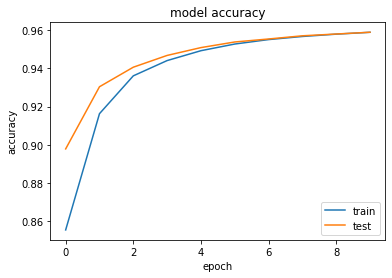

In [35]:
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [36]:
loss = rnn_training.history['acc']
val_loss = rnn_training.history['val_acc']

In [37]:
loss
val_loss

[0.8978774547576904,
 0.9304236173629761,
 0.9406582713127136,
 0.9468249082565308,
 0.9509254693984985,
 0.9538659453392029,
 0.9554312229156494,
 0.9571018815040588,
 0.9580339193344116,
 0.9589636921882629]

||\\\\

In [38]:
import tensorflow as tf
rnn_model_t1 = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model_t1.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        trainable     =  False                    # False - don't update the embeddings
))

# add an RNN layer which contains 64 RNN cells
rnn_model_t1.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model_t1.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [39]:
rnn_model_t1.compile(loss      =  'categorical_crossentropy',
                  optimizer =  optimizer,
                  metrics   =  ['acc'])

In [40]:
rnn_model_t1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100, 64)           23360     
                                                                 
 time_distributed_1 (TimeDis  (None, 100, 13)          845       
 tributed)                                                       
                                                                 
Total params: 17,858,905
Trainable params: 24,205
Non-trainable params: 17,834,700
_________________________________________________________________


In [41]:
rnn_training_t1 = rnn_model_t1.fit(X_train, Y_train, batch_size=128, epochs=5, validation_data=(X_validation, Y_validation))

Epoch 1/5
408/408 [==============================] - 37s 88ms/step - loss: 0.9388 - acc: 0.7975 - val_loss: 0.6213 - val_acc: 0.8311
Epoch 2/5
408/408 [==============================] - 38s 92ms/step - loss: 0.5593 - acc: 0.8352 - val_loss: 0.5235 - val_acc: 0.8356
Epoch 3/5
408/408 [==============================] - 36s 89ms/step - loss: 0.4945 - acc: 0.8387 - val_loss: 0.4823 - val_acc: 0.8387
Epoch 4/5
408/408 [==============================] - 36s 89ms/step - loss: 0.4699 - acc: 0.8433 - val_loss: 0.4609 - val_acc: 0.8501
Epoch 5/5
408/408 [==============================] - 36s 89ms/step - loss: 0.4479 - acc: 0.8612 - val_loss: 0.4381 - val_acc: 0.8699


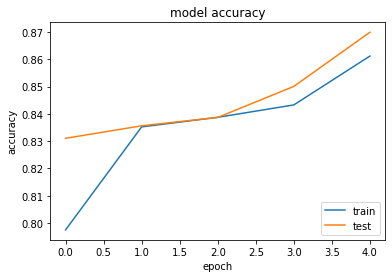

In [42]:
plt.plot(rnn_training_t1.history['acc'])
plt.plot(rnn_training_t1.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [43]:
loss_t1 = rnn_training_t1.history['acc']
val_loss_t1 = rnn_training_t1.history['val_acc']

In [44]:
loss_t1
val_loss_t1

[0.8310526013374329,
 0.8356441259384155,
 0.8387041091918945,
 0.8500836491584778,
 0.86993807554245]

In [45]:
rnn_model_t2 = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model_t2.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        trainable     =  False                    # False - don't update the embeddings
))

# add an RNN layer which contains 64 RNN cells
rnn_model_t2.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model_t2.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [46]:
rnn_model_t2.compile(loss      =  tf.losses.MeanSquaredError(),
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [47]:
rnn_model_t2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 100, 64)           23360     
                                                                 
 time_distributed_2 (TimeDis  (None, 100, 13)          845       
 tributed)                                                       
                                                                 
Total params: 17,858,905
Trainable params: 24,205
Non-trainable params: 17,834,700
_________________________________________________________________


In [48]:
rnn_training_t2 = rnn_model_t2.fit(X_train, Y_train, batch_size=64, epochs=5, validation_data=(X_validation, Y_validation))

Epoch 1/5
816/816 [==============================] - 43s 51ms/step - loss: 0.0120 - acc: 0.8856 - val_loss: 0.0078 - val_acc: 0.9278
Epoch 2/5
816/816 [==============================] - 41s 51ms/step - loss: 0.0066 - acc: 0.9387 - val_loss: 0.0059 - val_acc: 0.9457
Epoch 3/5
816/816 [==============================] - 42s 51ms/step - loss: 0.0055 - acc: 0.9499 - val_loss: 0.0052 - val_acc: 0.9532
Epoch 4/5
816/816 [==============================] - 42s 52ms/step - loss: 0.0050 - acc: 0.9553 - val_loss: 0.0049 - val_acc: 0.9565
Epoch 5/5
816/816 [==============================] - 42s 51ms/step - loss: 0.0048 - acc: 0.9578 - val_loss: 0.0047 - val_acc: 0.9575


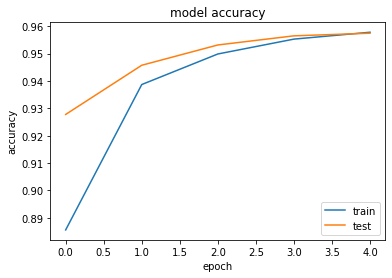

In [49]:
plt.plot(rnn_training_t2.history['acc'])
plt.plot(rnn_training_t2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [50]:
loss_t2 = rnn_training_t2.history['acc']
val_loss_t2 = rnn_training_t2.history['val_acc']

In [51]:
loss_t2
val_loss_t2

[0.9277677536010742,
 0.9457418918609619,
 0.953154444694519,
 0.9564892649650574,
 0.9574527740478516]

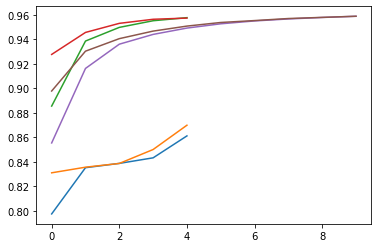

In [61]:
plt.plot(rnn_training_t1.history['acc'])
plt.plot(rnn_training_t1.history['val_acc'])
plt.plot(rnn_training_t2.history['acc'])
plt.plot(rnn_training_t2.history['val_acc'])
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])

|||||\\

In [53]:
rnn_model_t3 = Sequential()


rnn_model_t3.add(Embedding(input_dim     =  VOCABULARY_SIZE,         
                        output_dim    =  EMBEDDING_SIZE,          
                        input_length  =  MAX_SEQ_LENGTH,          
                        trainable     =  True                     
))


rnn_model_t3.add(SimpleRNN(64, 
              return_sequences=True  
))

rnn_model_t3.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [54]:
rnn_model_t3.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [55]:
rnn_model_t3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 100, 64)           23360     
                                                                 
 time_distributed_3 (TimeDis  (None, 100, 13)          845       
 tributed)                                                       
                                                                 
Total params: 17,858,905
Trainable params: 17,858,905
Non-trainable params: 0
_________________________________________________________________


In [56]:
rnn_training_t3 = rnn_model.fit(X_train, Y_train, batch_size=64, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
816/816 [==============================] - 45s 55ms/step - loss: 0.1187 - acc: 0.9597 - val_loss: 0.1188 - val_acc: 0.9589
Epoch 2/10
816/816 [==============================] - 45s 55ms/step - loss: 0.1155 - acc: 0.9606 - val_loss: 0.1156 - val_acc: 0.9603
Epoch 3/10
816/816 [==============================] - 45s 56ms/step - loss: 0.1130 - acc: 0.9614 - val_loss: 0.1129 - val_acc: 0.9614
Epoch 4/10
816/816 [==============================] - 45s 55ms/step - loss: 0.1109 - acc: 0.9620 - val_loss: 0.1108 - val_acc: 0.9619
Epoch 5/10
816/816 [==============================] - 64s 78ms/step - loss: 0.1087 - acc: 0.9627 - val_loss: 0.1091 - val_acc: 0.9624
Epoch 6/10
816/816 [==============================] - 47s 57ms/step - loss: 0.1067 - acc: 0.9635 - val_loss: 0.1078 - val_acc: 0.9632
Epoch 7/10
816/816 [==============================] - 46s 56ms/step - loss: 0.1046 - acc: 0.9642 - val_loss: 0.1051 - val_acc: 0.9639
Epoch 8/10
816/816 [==============================] - 45s 55ms

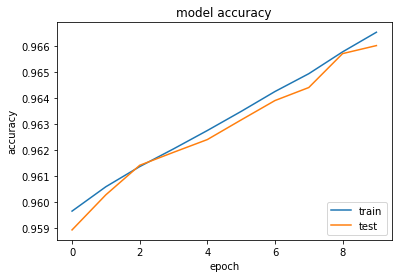

In [57]:
plt.plot(rnn_training_t3.history['acc'])
plt.plot(rnn_training_t3.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [58]:
loss_t3 = rnn_training_t3.history['acc']
val_loss_t3 = rnn_training_t3.history['val_acc']

In [59]:
loss_t3
val_loss_t3

[0.9589343667030334,
 0.9602824449539185,
 0.9614142775535583,
 0.9619128704071045,
 0.9624016880989075,
 0.9631555676460266,
 0.9638996124267578,
 0.9643992781639099,
 0.965701699256897,
 0.9660091400146484]

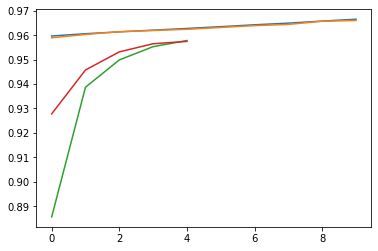

In [60]:
plt.plot(rnn_training_t3.history['acc'])
plt.plot(rnn_training_t3.history['val_acc'])
plt.plot(rnn_training_t2.history['acc'])
plt.plot(rnn_training_t2.history['val_acc'])

LTSM

In [62]:
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim     = VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                         output_dim    = EMBEDDING_SIZE,          # length of vector with which each word is represented
                         input_length  = MAX_SEQ_LENGTH,          # length of input sequence
                         weights       = [embedding_weights],     # word embedding matrix
                         trainable     = True                     # True - update embeddings_weight matrix
))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [63]:
lstm_model.compile(loss      =  'categorical_crossentropy',
                   optimizer =  'adam',
                   metrics   =  ['acc'])

In [64]:
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 lstm (LSTM)                 (None, 100, 64)           93440     
                                                                 
 time_distributed_4 (TimeDis  (None, 100, 13)          845       
 tributed)                                                       
                                                                 
Total params: 17,928,985
Trainable params: 17,928,985
Non-trainable params: 0
_________________________________________________________________


In [65]:
lstm_training = lstm_model.fit(X_train, Y_train, batch_size=64, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
816/816 [==============================] - 310s 376ms/step - loss: 0.1738 - acc: 0.9595 - val_loss: 0.0328 - val_acc: 0.9891
Epoch 2/10
816/816 [==============================] - 302s 371ms/step - loss: 0.0254 - acc: 0.9911 - val_loss: 0.0263 - val_acc: 0.9904
Epoch 3/10
816/816 [==============================] - 305s 374ms/step - loss: 0.0192 - acc: 0.9930 - val_loss: 0.0247 - val_acc: 0.9910
Epoch 4/10
816/816 [==============================] - 306s 375ms/step - loss: 0.0164 - acc: 0.9940 - val_loss: 0.0244 - val_acc: 0.9913
Epoch 5/10
816/816 [==============================] - 304s 373ms/step - loss: 0.0142 - acc: 0.9948 - val_loss: 0.0245 - val_acc: 0.9916
Epoch 6/10
816/816 [==============================] - 305s 374ms/step - loss: 0.0123 - acc: 0.9955 - val_loss: 0.0248 - val_acc: 0.9917
Epoch 7/10
816/816 [==============================] - 307s 376ms/step - loss: 0.0106 - acc: 0.9962 - val_loss: 0.0257 - val_acc: 0.9916
Epoch 8/10
816/816 [============================

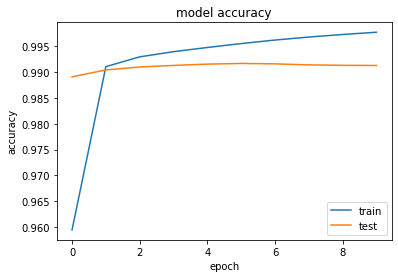

In [66]:
plt.plot(lstm_training.history['acc'])
plt.plot(lstm_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [67]:
loss_ltsm = lstm_training.history['acc']
val_loss_ltsm = lstm_training.history['val_acc']

In [68]:
loss_ltsm
val_loss_ltsm

[0.9890897274017334,
 0.9904312491416931,
 0.9909982681274414,
 0.9913024306297302,
 0.9915533065795898,
 0.9916858673095703,
 0.991607666015625,
 0.9914034605026245,
 0.9913263320922852,
 0.9912893772125244]

GRU

In [69]:
gru_model = Sequential()
gru_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                        output_dim    = EMBEDDING_SIZE,
                        input_length  = MAX_SEQ_LENGTH,
                        weights       = [embedding_weights],
                        trainable     = True
))
gru_model.add(GRU(64, return_sequences=True))
gru_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [70]:
gru_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [71]:
gru_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 gru (GRU)                   (None, 100, 64)           70272     
                                                                 
 time_distributed_5 (TimeDis  (None, 100, 13)          845       
 tributed)                                                       
                                                                 
Total params: 17,905,817
Trainable params: 17,905,817
Non-trainable params: 0
_________________________________________________________________


In [72]:
gru_training = gru_model.fit(X_train, Y_train, batch_size=64, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
816/816 [==============================] - 287s 349ms/step - loss: 0.1311 - acc: 0.9726 - val_loss: 0.0293 - val_acc: 0.9896
Epoch 2/10
816/816 [==============================] - 282s 345ms/step - loss: 0.0228 - acc: 0.9917 - val_loss: 0.0253 - val_acc: 0.9906
Epoch 3/10
816/816 [==============================] - 285s 349ms/step - loss: 0.0179 - acc: 0.9933 - val_loss: 0.0242 - val_acc: 0.9911
Epoch 4/10
816/816 [==============================] - 285s 349ms/step - loss: 0.0156 - acc: 0.9941 - val_loss: 0.0240 - val_acc: 0.9913
Epoch 5/10
816/816 [==============================] - 283s 347ms/step - loss: 0.0138 - acc: 0.9948 - val_loss: 0.0244 - val_acc: 0.9914
Epoch 6/10
816/816 [==============================] - 283s 347ms/step - loss: 0.0121 - acc: 0.9955 - val_loss: 0.0249 - val_acc: 0.9915
Epoch 7/10
816/816 [==============================] - 283s 347ms/step - loss: 0.0104 - acc: 0.9962 - val_loss: 0.0261 - val_acc: 0.9914
Epoch 8/10
816/816 [============================

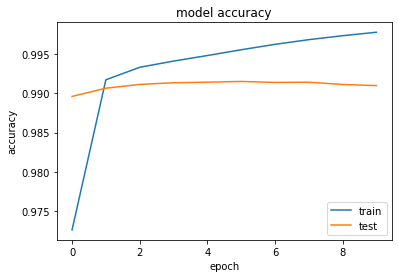

In [73]:
plt.plot(gru_training.history['acc'])
plt.plot(gru_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [74]:
loss_gru = gru_training.history['acc']
val_loss_gru = gru_training.history['val_acc']

In [75]:
loss_gru
val_loss_gru

[0.9895926713943481,
 0.990632176399231,
 0.9911166429519653,
 0.9913241267204285,
 0.9913991093635559,
 0.991492509841919,
 0.9913697838783264,
 0.9913958311080933,
 0.9911090731620789,
 0.9909623861312866]

Bidirectional LSTM

In [76]:
bidirect_model = Sequential()
bidirect_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                             output_dim    = EMBEDDING_SIZE,
                             input_length  = MAX_SEQ_LENGTH,
                             weights       = [embedding_weights],
                             trainable     = True
))
bidirect_model.add(Bidirectional(LSTM(64, return_sequences=True)))
bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [77]:
bidirect_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [78]:
bidirect_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         186880    
 l)                                                              
                                                                 
 time_distributed_6 (TimeDis  (None, 100, 13)          1677      
 tributed)                                                       
                                                                 
Total params: 18,023,257
Trainable params: 18,023,257
Non-trainable params: 0
_________________________________________________________________


In [79]:
bidirect_training = bidirect_model.fit(X_train, Y_train, batch_size=64, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
816/816 [==============================] - 459s 558ms/step - loss: 0.1333 - acc: 0.9670 - val_loss: 0.0234 - val_acc: 0.9921
Epoch 2/10
816/816 [==============================] - 452s 554ms/step - loss: 0.0168 - acc: 0.9943 - val_loss: 0.0189 - val_acc: 0.9935
Epoch 3/10
816/816 [==============================] - 452s 553ms/step - loss: 0.0114 - acc: 0.9962 - val_loss: 0.0181 - val_acc: 0.9940
Epoch 4/10
816/816 [==============================] - 454s 556ms/step - loss: 0.0084 - acc: 0.9972 - val_loss: 0.0178 - val_acc: 0.9943
Epoch 5/10
816/816 [==============================] - 447s 548ms/step - loss: 0.0060 - acc: 0.9981 - val_loss: 0.0185 - val_acc: 0.9943
Epoch 6/10
816/816 [==============================] - 447s 548ms/step - loss: 0.0043 - acc: 0.9986 - val_loss: 0.0199 - val_acc: 0.9942
Epoch 7/10
816/816 [==============================] - 450s 551ms/step - loss: 0.0030 - acc: 0.9991 - val_loss: 0.0218 - val_acc: 0.9940
Epoch 8/10
816/816 [============================

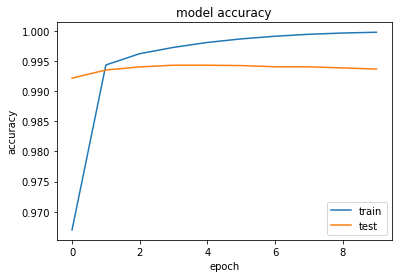

In [80]:
plt.plot(bidirect_training.history['acc'])
plt.plot(bidirect_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [81]:
loss_b = bidirect_training.history['acc']
val_loss_b = bidirect_training.history['val_acc']

In [82]:
loss_b
val_loss_b

[0.9921431541442871,
 0.9934900999069214,
 0.9940038919448853,
 0.9942863583564758,
 0.9942874312400818,
 0.9942233562469482,
 0.9940343499183655,
 0.9940223693847656,
 0.9938387870788574,
 0.9936443567276001]

Model evaluation

In [83]:
loss, accuracy = rnn_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

339/339 [==============================] - 6s 18ms/step - loss: 0.0981 - acc: 0.9663
Loss: 0.09812648594379425,
Accuracy: 0.9662755131721497


In [84]:
loss, accuracy = lstm_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

339/339 [==============================] - 9s 28ms/step - loss: 0.0293 - acc: 0.9914
Loss: 0.02934468910098076,
Accuracy: 0.9914015531539917


In [85]:
loss, accuracy = gru_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

339/339 [==============================] - 8s 23ms/step - loss: 0.0304 - acc: 0.9912
Loss: 0.030376117676496506,
Accuracy: 0.9911965727806091


In [86]:
loss, accuracy = bidirect_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

339/339 [==============================] - 16s 47ms/step - loss: 0.0262 - acc: 0.9938
Loss: 0.026186702772974968,
Accuracy: 0.9938297271728516


In [87]:
from nltk.corpus import stopwords
nltk.download('stopwords')
def getdictWithoutStopWords (text2):
  DataSet = open(text2, "r", encoding="utf-8")
  text = DataSet.read()
  english_stopwords = stopwords.words("english")
  english_stopwords.extend([',', '.','-','!','?','\'s','|',';',])
  text_tokens = word_tokenize(text)
  text = nltk.Text(text_tokens)
  text_tokens = [token.strip() for token in text_tokens if token not in english_stopwords]
  fdist = FreqDist(text)
  tagged = nltk.pos_tag(text)
  text = nltk.Text(text_tokens)
  fdist_sw = FreqDist(text)
  fdist_sw.most_common(20)
  fdist_sw.plot(20,cumulative=False)
  #print(type(text_tokens), len(text_tokens))
  print('Частотная встречаемость по словам в тексте',fdist_sw.most_common(20))
  print('CC Координирующее соединение\nCD Кардинальная цифра\nВ Предлог\nJJ Прилагательное\nJJR Прилагательное, сравнительное\nJJS Прилагательное, превосходное\nНН Существительное\nPRP Личное местоимение\nPRP $ Притяжательное местоимение\nRB Наречие\nRP Частица\nVBD Глагол ')
  print(tagged[:20])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [88]:
from nltk import word_tokenize
nltk.download('punkt')
from nltk.probability import FreqDist
import nltk
nltk.download('averaged_perceptron_tagger')
def getdict (text2):
  DataSet = open(text2, "r", encoding="utf-8")
  text = DataSet.read()
  text_tokens = word_tokenize(text)
  text = nltk.Text(text_tokens)
  fdist = FreqDist(text)
  tagged = nltk.pos_tag(text)
  #print(type(text_tokens), len(text_tokens))
  print('Частотная встречаемость по словам в тексте',fdist.most_common(20))
  print('CC Координирующее соединение\nCD Кардинальная цифра\nВ Предлог\nJJ Прилагательное\nJJR Прилагательное, сравнительное\nJJS Прилагательное, превосходное\nНН Существительное\nPRP Личное местоимение\nPRP $ Притяжательное местоимение\nRB Наречие\nRP Частица\nVBD Глагол ')
  print(tagged[:20])
  fdist.plot(20,cumulative=False)
  #print(tagged)
  #text_tokens[:20]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Частотная встречаемость по словам в тексте [(',', 94), ('the', 50), ('.', 33), ('of', 32), ('and', 31), ('he', 24), ('to', 23), ('was', 22), ('in', 19), ('a', 17), ('his', 14), ('that', 14), ('with', 11), ('I', 11), ('at', 10), ('time', 10), ('all', 9), ('not', 8), ('it', 8), ('young', 7)]
CC Координирующее соединение
CD Кардинальная цифра
В Предлог
JJ Прилагательное
JJR Прилагательное, сравнительное
JJS Прилагательное, превосходное
НН Существительное
PRP Личное местоимение
PRP $ Притяжательное местоимение
RB Наречие
RP Частица
VBD Глагол 
[('At', 'IN'), ('the', 'DT'), ('beginning', 'NN'), ('of', 'IN'), ('July', 'NNP'), (',', ','), ('at', 'IN'), ('an', 'DT'), ('extremely', 'RB'), ('hot', 'JJ'), ('time', 'NN'), (',', ','), ('in', 'IN'), ('the', 'DT'), ('evening', 'NN'), (',', ','), ('one', 'CD'), ('young', 'JJ'), ('man', 'NN'), ('came', 'VBD')]


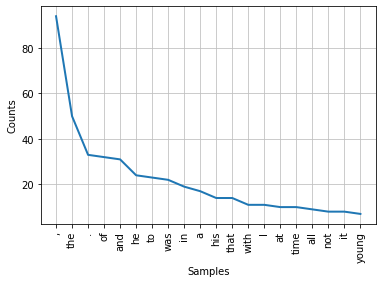

In [89]:
getdict('/content/drive/MyDrive/LrNK/test_text.txt')

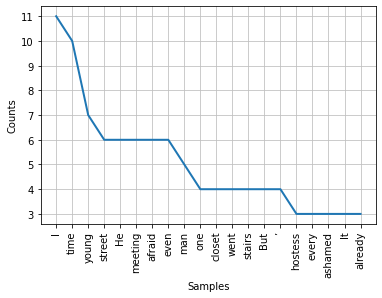

Частотная встречаемость по словам в тексте [('I', 11), ('time', 10), ('young', 7), ('street', 6), ('He', 6), ('meeting', 6), ('afraid', 6), ('even', 6), ('man', 5), ('one', 4), ('closet', 4), ('went', 4), ('stairs', 4), ('But', 4), ('’', 4), ('hostess', 3), ('every', 3), ('ashamed', 3), ('It', 3), ('already', 3)]
CC Координирующее соединение
CD Кардинальная цифра
В Предлог
JJ Прилагательное
JJR Прилагательное, сравнительное
JJS Прилагательное, превосходное
НН Существительное
PRP Личное местоимение
PRP $ Притяжательное местоимение
RB Наречие
RP Частица
VBD Глагол 
[('At', 'IN'), ('the', 'DT'), ('beginning', 'NN'), ('of', 'IN'), ('July', 'NNP'), (',', ','), ('at', 'IN'), ('an', 'DT'), ('extremely', 'RB'), ('hot', 'JJ'), ('time', 'NN'), (',', ','), ('in', 'IN'), ('the', 'DT'), ('evening', 'NN'), (',', ','), ('one', 'CD'), ('young', 'JJ'), ('man', 'NN'), ('came', 'VBD')]


In [90]:
getdictWithoutStopWords('/content/drive/MyDrive/LrNK/test_text.txt')